<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт библиотек

In [1]:
#!pip install --no-cache-dir wordcloud

In [2]:
import numpy as np
import os
import pandas as pd
import torch
import transformers
#import tqdm
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
import warnings
#warnings.filterwarnings("ignore")
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.tree import DecisionTreeClassifier

import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_STATE = 42

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jenechka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jenechka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Загрузка данных 

In [3]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    toxic_comments = pd.read_csv(pth1)
elif os.path.exists(pth2):
    toxic_comments = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


### Предобработка данных

In [4]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
toxic_comments['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

Негативных комментариев меньше, необходимо будет это учесть при создании выборок, применяя stratify.

Проверим на пропуски и дубликаты.

In [6]:
toxic_comments.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
toxic_comments.duplicated().sum()

0

Так как вычислительные ресурсы ограничены, возьмем выборку из 30000 строк, ее будет достаточно для выполнения поставленной задачи.

In [8]:
toxic_comments = toxic_comments.drop('Unnamed: 0', axis=1)

In [9]:
toxic_comments = toxic_comments.sample(30000, random_state=RANDOM_STATE)

## Подготовка признаков

Напишем функции для категоризации слов по частям речи и лемматизации текста с использованием библиотеки NLTK.

In [10]:
def determine_word_category(word):
    pos_tag = nltk.pos_tag([word])[0][1][0].upper()
    
    if pos_tag == "J":
        return wordnet.ADJ
    elif pos_tag == "N":
        return wordnet.NOUN
    elif pos_tag == "V":
        return wordnet.VERB
    elif pos_tag == "R":
        return wordnet.ADV
    else:
        return wordnet.NOUN 

In [11]:
def lemmatize(text):
    m = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    return ' '.join([m.lemmatize(i, determine_word_category(i)) for i in text])

In [12]:
tqdm.pandas()
toxic_comments['text'] = toxic_comments['text'].progress_apply(lemmatize)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [18:25<00:00, 27.13it/s]


In [13]:
text_cloud = ' '.join(toxic_comments['text'])

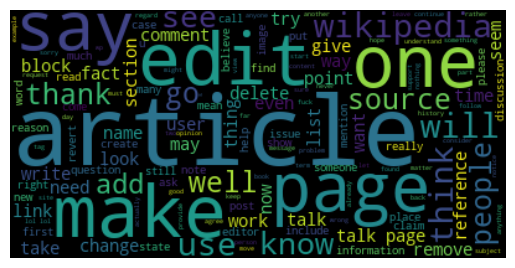

In [14]:
wordcloud = WordCloud().generate(text_cloud)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.show()  

## Обучение моделей

Так как в проекте поставлена задача бинарной классификации, будем использовать логистическую регрессию.

Выделим обучающую и тренировочную выборки

In [15]:
y = toxic_comments['toxic']
X = toxic_comments.drop('toxic', axis=1)  


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

In [17]:
stopwords = list(set(stopwords.words('english')))

Создадим пайплайн для логистической регресcии

In [18]:
from sklearn.pipeline import Pipeline, FeatureUnion
pipe_final = Pipeline([
    ('features', FeatureUnion([
        ('count_vect', CountVectorizer()),
        ('tfidf_vect', TfidfVectorizer())
    ])),
    ('models', LogisticRegression())
])

In [19]:
param_distributions = [
    {
        'models': [LogisticRegression()],
        'models__max_iter': [500],
        'models__penalty': ['l2'],
        'models__C': [50, 80, 100, 120],
        'models__class_weight': ['balanced']
    },
    {
        'models': [DecisionTreeClassifier()],
        'models__max_depth': [ 10, 50, 100, 300],
        'models__class_weight': ['balanced']
    }
]

In [20]:
grid_search_cv = GridSearchCV(
    pipe_final, 
    param_distributions, 
    cv = 5,
    scoring='f1', 
    n_jobs=-1
)
grid_search_cv.fit(X_train['text'], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('count_vect',
                                                                        CountVectorizer()),
                                                                       ('tfidf_vect',
                                                                        TfidfVectorizer())])),
                                       ('models', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression()],
                          'models__C': [50, 80, 100, 120],
                          'models__class_weight': ['balanced'],
                          'models__max_iter': [500],
                          'models__penalty': ['l2']},
                         {'models': [DecisionTreeClassifier()],
                          'models__class_weight': ['balanced'],
                          'models__max_depth': [10, 50, 100, 300]}],
             scoring='f1')

In [21]:
print('Лучший результат на тренировочной выборке для каждой модели:')
for i, params in enumerate(grid_search_cv.cv_results_['params']):
    print(f"Модель {i+1}: {grid_search_cv.cv_results_['mean_test_score'][i]:.2f}, Параметры: {params}")

Лучший результат на тренировочной выборке для каждой модели:
Модель 1: 0.74, Параметры: {'models': LogisticRegression(), 'models__C': 50, 'models__class_weight': 'balanced', 'models__max_iter': 500, 'models__penalty': 'l2'}
Модель 2: 0.74, Параметры: {'models': LogisticRegression(), 'models__C': 80, 'models__class_weight': 'balanced', 'models__max_iter': 500, 'models__penalty': 'l2'}
Модель 3: 0.74, Параметры: {'models': LogisticRegression(), 'models__C': 100, 'models__class_weight': 'balanced', 'models__max_iter': 500, 'models__penalty': 'l2'}
Модель 4: 0.74, Параметры: {'models': LogisticRegression(), 'models__C': 120, 'models__class_weight': 'balanced', 'models__max_iter': 500, 'models__penalty': 'l2'}
Модель 5: 0.38, Параметры: {'models': DecisionTreeClassifier(), 'models__class_weight': 'balanced', 'models__max_depth': 10}
Модель 6: 0.51, Параметры: {'models': DecisionTreeClassifier(), 'models__class_weight': 'balanced', 'models__max_depth': 50}
Модель 7: 0.51, Параметры: {'models

In [22]:
best_model_LR = grid_search_cv.best_estimator_

In [23]:
print("Лучшие параметры:", grid_search_cv.best_params_)
print("Метрика лучшей модели (средняя точность на кросс-валидации):", grid_search_cv.best_score_)

Лучшие параметры: {'models': LogisticRegression(), 'models__C': 120, 'models__class_weight': 'balanced', 'models__max_iter': 500, 'models__penalty': 'l2'}
Метрика лучшей модели (средняя точность на кросс-валидации): 0.742145829613782


На кросс-валидации лучший результат показала модель с параметрами {'models': LogisticRegression(), 'models__C': 120, 'models__penalty': 'l2'}. Ее выберем для тестирования.  

### Тестирование лучшей модели.

In [24]:
predictions = best_model_LR.predict(X_test['text'])
score = f1_score(y_test, predictions)
print(f'F1 score модели LogisticRegression: {score:.3f}')

F1 score модели LogisticRegression: 0.759


Метрика больше 0.75, что удовлетворяет условию.

## Выводы

В проекте для интернет-магазина «Викишоп» была поставлена задача разработать модель классификации комментариев пользователей на позитивные и негативные.
Для решения данной задачи датасет был предобработан, из него были выделены случайным образом 30000 строк для тренировочной и тестовой выборки.
Для подготовки датасета была реализована категоризация слова по его части речи и лемматизация с использованием библиотеки NLTK. Тренировочная и тестовая выборки были векторизированы отдельно, чтобы избежать утечки данных. Так как была поставлена задача бинарной классификации, то была выбрана модель логистической регрессии и дерево решений. На кросс-валидации лучший результат показала логистической регрессии. На тестовой выборке получена метрика 0.76, что удовлетворяет условию задания: Модель классифицирует комментарии на позитивные и негативные с F1-метрикой не менее 0.75. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны